In [33]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # 添加这行
import re

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
import seaborn as sns
sns.set_style("whitegrid")

In [34]:
# metric in long-term-forecasting
# mae, mse, rmse, mape, mspe

In [35]:
def radar_factory(num_vars, frame="circle"):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2 * np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):
        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):
        name = "radar"
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location("N")

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        # def set_varlabels(self, labels):
        #     self.set_thetagrids(np.degrees(theta), labels)
        #

        def set_varlabels(self, labels, fontsize=10,
                          fontweight='bold'):  # Added fontweight parameter with a default value
            self.set_thetagrids(np.degrees(theta), labels, fontsize=fontsize, fontweight=fontweight)



        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == "circle":
                return Circle((0.5, 0.5), 0.5)
            elif frame == "polygon":
                return RegularPolygon((0.5, 0.5), num_vars, radius=0.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == "circle":
                return super()._gen_axes_spines()
            elif frame == "polygon":
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(
                    axes=self,
                    spine_type="circle",
                    path=Path.unit_regular_polygon(num_vars),
                )
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(
                    Affine2D().scale(0.5).translate(0.5, 0.5) + self.transAxes
                )
                return {"polar": spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [36]:
path = '/data/nishome/user1/minqi/TSGym/results_long_term_forecasting'
datasets = sorted(os.listdir(os.path.join(path, f'resultsGym_non_transformer')))
datasets = [_ for _ in datasets if _ != 'ili']
result_dict, runtime_dict = {}, {}
for dataset in datasets:
    result_dict[dataset], runtime_dict[dataset] = {}, {}
    pred_lens = [96, 192, 336, 720] if dataset not in ['ili', 'fred-md', 'covid-19'] else [24, 36, 48, 60]
    for pred_len in pred_lens:
        file_list = os.listdir(os.path.join(path, f'resultsGym_non_transformer', dataset)) +\
                    os.listdir(os.path.join(path, f'resultsGym_transformer', dataset))
        file_list = [_ for _ in file_list if f'pl{pred_len}' in _]
        result_dict[dataset][pred_len], runtime_dict[dataset][pred_len] = {}, {}
        for file in file_list:
            try:
                result = np.load(os.path.join(path, f'resultsGym_non_transformer', dataset, file, 'metrics.npy'), allow_pickle=True)
            except:
                try:
                    result = np.load(os.path.join(path, f'resultsGym_transformer', dataset, file, 'metrics.npy'), allow_pickle=True)
                except:
                    continue
            result_dict[dataset][pred_len][file] = result[1]

        # metrics = result_dict[dataset][pred_len].values()
        # metrics = np.array(list(metrics))
        # metrics = np.argsort(np.argsort(metrics))
        # metrics = (metrics + 1) / len(metrics)

        # result_dict[dataset][pred_len] = {k: metrics[i] for i, k in enumerate(result_dict[dataset][pred_len].keys())}

result_dict_vis = result_dict.copy()
for dataset in datasets:
    pred_lens = [96, 192, 336, 720] if dataset not in ['ili', 'fred-md', 'covid-19'] else [24, 36, 48, 60]
    for pred_len in pred_lens:
        result_dict_vis[dataset][pred_len] = {'_'.join([k[k.find('TSGym')+6: k.find('ftM')-1],
                                            re.search(r'sl(\d+)', k)[0],
                                            re.search(r'dm(\d+)', k)[0],
                                            re.search(r'df(\d+)', k)[0],
                                            re.search(r'el(\d+)', k)[0],
                                            re.search(r'epochs(\d+)', k)[0],
                                            re.search(r'lf([A-Za-z]+)', k)[0],
                                            re.search(r'lr(\d+(?:\.\d+)?)', k)[0],
                                            re.search(r'lrs([A-Za-z]+)', k)[0]]):v for k, v in result_dict_vis[dataset][pred_len].items()}

In [42]:
# todo: NaN values?
intros = ['x_mark', 'multi-granularity', 'Normalization', 'Decomposition', 'Channel-independent',
          'Tokenization', 'Backbone', 'Attention', 'Feature-Attention', 'Encoder-only', 'Frozen', 'Dataset',
          'Sequence Length', 'd_model', 'd_ff', 'Encoder layers',
          'Training Epochs', 'Loss Function', 'Learning Rate', 'Learning Rate Strategy']
# ... existing code ...
dict_compoents2mse_mean = {}
dict_compoents2mse_25percent = {}
n=0; 
while True:
    intro = intros[n]
    all_comps = []
    dict_compoents2mse_mean[intro] = {}
    dict_compoents2mse_25percent[intro] = {}
    
    # 收集所有可能的comps
    for dataset in datasets:
        pred_len = 96 if dataset not in ['ili', 'fred-md', 'covid-19'] else 24
        comps = set([_.split('_')[n] for _ in result_dict_vis[dataset][pred_len].keys()])
        all_comps.extend(comps)
    unique_comps = sorted(list(set(all_comps)))
    if len(unique_comps) <= 1 or 'custom' in unique_comps: 
        n +=1
        continue
    
    for i,comp in enumerate(unique_comps):
        dict_compoents2mse_mean[intro][comp] = {}
        dict_compoents2mse_25percent[intro][comp] = {}
        for j,dataset in enumerate(datasets):
            pred_len = 96 if dataset not in ['ili', 'fred-md', 'covid-19'] else 24
            v = np.array([val for key, val in result_dict_vis[dataset][pred_len].items() 
                        if key.split('_')[n] == comp])
            v = v[~np.isnan(v)]
            v = v[v < 1e+4]
            if len(v) <= 1: continue
            dict_compoents2mse_mean[intro][comp][dataset] = v.mean()
            dict_compoents2mse_25percent[intro][comp][dataset] = np.percentile(v,25)
            # print(dict_compoents2mse_std[intro][comp][dataset])
        if len(dict_compoents2mse_mean[intro][comp]) != len(datasets):
            del dict_compoents2mse_mean[intro][comp]
            del dict_compoents2mse_25percent[intro][comp]
            
    n +=1
    if n >= len(intros): break

In [43]:
def get_data(dict_dimensions,design_dimensions):
    data = []
    data.append(datasets)
    data.append((design_dimensions,[list(dict_dimensions[comp].values()) for comp in list(dict_dimensions.keys())]))
    return data

In [62]:
def plot_function(dict_compoents2mse,design_dimension):
    N = 8
    theta = radar_factory(N, frame="polygon")

    fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(projection="radar"))
    fig.subplots_adjust(top=0.85, bottom=0.15)

    data = get_data(dict_compoents2mse[design_dimension],design_dimension)
    spoke_labels = data.pop(0)

    colors = ["#d52627", "#3181ba", "#9366bc", "#f39844", "#4fad59", "#eb3891", "#fffff", "#ff6347"][:len(dict_compoents2mse[design_dimension].keys())]
    title, case_data = data[0]
    # 计算每个维度的最小值、25分位数和中位数
    min_values = np.array([np.min(d) for d in np.array(case_data).T])
    max_values = np.array([np.max(d) for d in np.array(case_data).T])

    case_data = [1 - 0.9 * (np.array(v) - min_values) / (max_values - min_values) for v in case_data]

    ax.set_rgrids([0, 0.2, 0.4, 0.6, 0.8, 1], ['', '', '', '', '', ''])

    # ax.set_title(
    #     title,
    #     weight="bold",
    #     size="large",
    #     position=(0.5, 1.1),
    #     horizontalalignment="center",
    #     verticalalignment="center",
    # )

    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color, linewidth=3)
        ax.fill(theta, d, facecolor=color, alpha=0, label="_nolegend_")
    ax.set_varlabels([],fontsize=18)

    labels = list(dict_compoents2mse[design_dimension].keys())
    legend = ax.legend(labels, ncol=2, loc='upper center', bbox_to_anchor=(0.485, -0.02), labelspacing=0.1,
                        prop={'size': 18, 'weight': 'bold'})

    plt.savefig(f'/data/nishome/user1/minqi/TSGym/meta_cc/design_choice_plot_radar_25percent/{design_dimension.replace(" ","-")}.pdf')
    plt.close()
    # plt.show()


In [63]:
from tqdm import tqdm
os.makedirs('/data/nishome/user1/minqi/TSGym/meta_cc/design_choice_plot_radar_25percent',exist_ok=True)
for design_dimension in tqdm(intros):
# design_dimension = intros[0]
    plot_function(dict_compoents2mse_25percent,design_dimension)

  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:01<00:00, 10.67it/s]/tmp/ipykernel_1953384/2380163204.py:17: RuntimeWarning: invalid value encountered in divide
  case_data = [1 - 0.9 * (np.array(v) - min_values) / (max_values - min_values) for v in case_data]
100%|██████████| 20/20 [00:02<00:00,  9.52it/s]


['ECL', 'ETTh1', 'ETTh2', 'ETTm1', 'ETTm2', 'Exchange', 'traffic', 'weather']


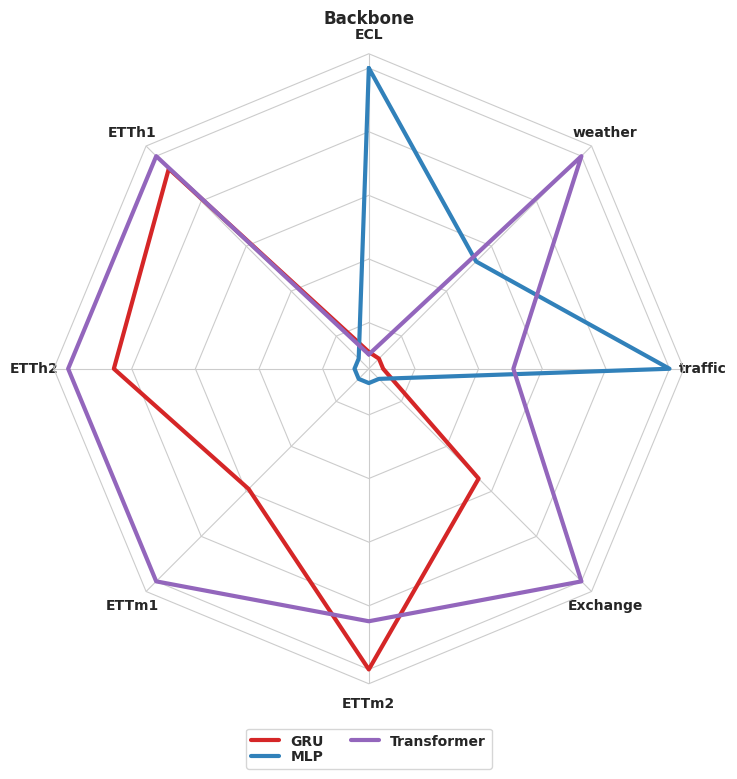

In [127]:
plot_function(dict_compoents2mse_std,'Backbone')

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
#d52627
[0.82439024 0.675      0.84347826 0.87142857 0.40288462 0.676
 0.9        0.75933148 0.76428571 0.95      ]
#3181ba
[0.1        0.1        0.1        0.1        0.30769231 0.496
 0.8        0.69791086 0.72142857 0.9       ]
#9366bc
[0.58292683 0.35       0.25652174 0.74285714 0.1        0.748
 0.63333333 0.52367688 0.67857143 0.425     ]
#f39844
[0.80243902 0.975      0.25652174 0.7        0.40288462 0.1
 0.6        0.1        0.1        0.1       ]
#4fad59
[0.36341463 0.625      0.33478261 0.57142857 0.12596154 0.712
 0.1        0.74554318 0.91428571 0.6       ]
#eb3891


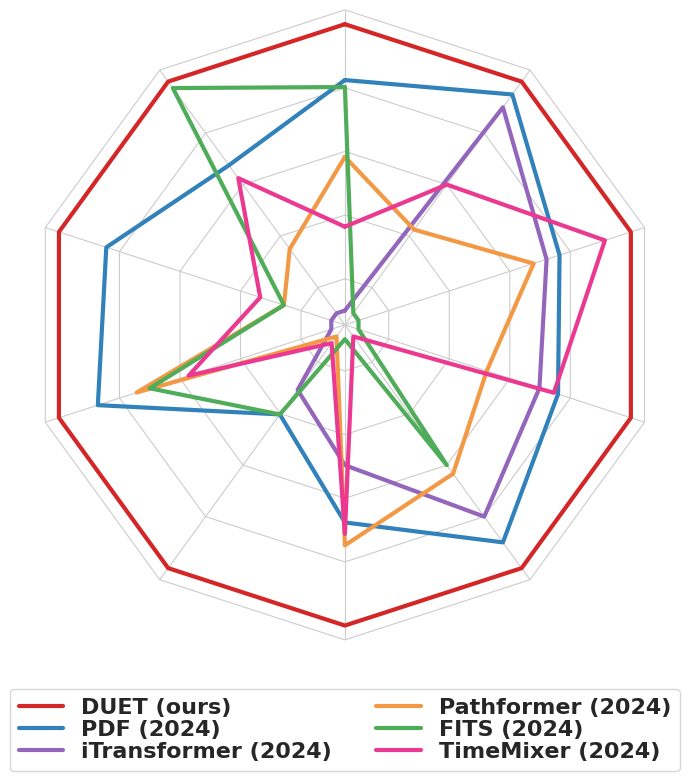

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.patches import Circle, RegularPolygon
# from matplotlib.path import Path
# from matplotlib.projections.polar import PolarAxes
# from matplotlib.projections import register_projection
# from matplotlib.spines import Spine
# from matplotlib.transforms import Affine2D


# def radar_factory(num_vars, frame="circle"):
#     """
#     Create a radar chart with `num_vars` axes.

#     This function creates a RadarAxes projection and registers it.

#     Parameters
#     ----------
#     num_vars : int
#         Number of variables for radar chart.
#     frame : {'circle', 'polygon'}
#         Shape of frame surrounding axes.

#     """
#     # calculate evenly-spaced axis angles
#     theta = np.linspace(0, 2 * np.pi, num_vars, endpoint=False)

#     class RadarTransform(PolarAxes.PolarTransform):
#         def transform_path_non_affine(self, path):
#             # Paths with non-unit interpolation steps correspond to gridlines,
#             # in which case we force interpolation (to defeat PolarTransform's
#             # autoconversion to circular arcs).
#             if path._interpolation_steps > 1:
#                 path = path.interpolated(num_vars)
#             return Path(self.transform(path.vertices), path.codes)

#     class RadarAxes(PolarAxes):
#         name = "radar"
#         PolarTransform = RadarTransform

#         def __init__(self, *args, **kwargs):
#             super().__init__(*args, **kwargs)
#             # rotate plot such that the first axis is at the top
#             self.set_theta_zero_location("N")

#         def fill(self, *args, closed=True, **kwargs):
#             """Override fill so that line is closed by default"""
#             return super().fill(closed=closed, *args, **kwargs)

#         def plot(self, *args, **kwargs):
#             """Override plot so that line is closed by default"""
#             lines = super().plot(*args, **kwargs)
#             for line in lines:
#                 self._close_line(line)

#         def _close_line(self, line):
#             x, y = line.get_data()
#             # FIXME: markers at x[0], y[0] get doubled-up
#             if x[0] != x[-1]:
#                 x = np.append(x, x[0])
#                 y = np.append(y, y[0])
#                 line.set_data(x, y)

#         # def set_varlabels(self, labels):
#         #     self.set_thetagrids(np.degrees(theta), labels)
#         #

#         def set_varlabels(self, labels, fontsize=20,
#                           fontweight='bold'):  # Added fontweight parameter with a default value
#             self.set_thetagrids(np.degrees(theta), [], fontsize=fontsize, fontweight=fontweight)



#         def _gen_axes_patch(self):
#             # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
#             # in axes coordinates.
#             if frame == "circle":
#                 return Circle((0.5, 0.5), 0.5)
#             elif frame == "polygon":
#                 return RegularPolygon((0.5, 0.5), num_vars, radius=0.5, edgecolor="k")
#             else:
#                 raise ValueError("Unknown value for 'frame': %s" % frame)

#         def _gen_axes_spines(self):
#             if frame == "circle":
#                 return super()._gen_axes_spines()
#             elif frame == "polygon":
#                 # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
#                 spine = Spine(
#                     axes=self,
#                     spine_type="circle",
#                     path=Path.unit_regular_polygon(num_vars),
#                 )
#                 # unit_regular_polygon gives a polygon of radius 1 centered at
#                 # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
#                 # 0.5) in axes coordinates.
#                 spine.set_transform(
#                     Affine2D().scale(0.5).translate(0.5, 0.5) + self.transAxes
#                 )
#                 return {"polar": spine}
#             else:
#                 raise ValueError("Unknown value for 'frame': %s" % frame)

#     register_projection(RadarAxes)
#     return theta


# def example_data():
#     data = [
#         [
#             "ETTh1",
#             "ETTh2",
#             "ETTm1",
#             "ETTm2",
#             "Exchange",
#             "Weather",
#             "Electricity",
#             "ILI",
#             "Solar",
#             "Traffic",
#         ],
#         (
#             "",
#             [
#                 [
#                     0.398,
#                     0.334,
#                     0.338,
#                     0.247,
#                     0.280,
#                     0.218,
#                     0.157,
#                     1.616,
#                     0.189,
#                     0.393,
#                 ],
#                 [
#                     0.406,
#                     0.347,
#                     0.342,
#                     0.250,
#                     0.349,
#                     0.227,
#                     0.160,
#                     1.808,
#                     0.2,
#                     0.395,
#                 ],
#                 [
#                     0.439,
#                     0.370,
#                     0.361,
#                     0.268,
#                     0.360,
#                     0.232,
#                     0.163,
#                     1.857,
#                     0.202,
#                     0.397,
#                 ],
#                 [
#                     0.417,
#                     0.360,
#                     0.357,
#                     0.253,
#                     0.384,
#                     0.225,
#                     0.168,
#                     1.996,
#                     0.204,
#                     0.416,
#                 ],
#                 [
#                     0.407,
#                     0.335,
#                     0.357,
#                     0.254,
#                     0.349,
#                     0.243,
#                     0.169,
#                     2.334,
#                     0.231,
#                     0.429,
#                 ],
#                 [
#                     0.427,
#                     0.349,
#                     0.355,
#                     0.257,
#                     0.381,
#                     0.226,
#                     0.184,
#                     1.819,
#                     0.193,
#                     0.409,
#                 ],
#             ],
#         ),
#     ]
#     return data


# if __name__ == "__main__":
#     N = 10
#     theta = radar_factory(N, frame="polygon")

#     data = example_data()
#     spoke_labels = data.pop(0)

#     fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(projection="radar"))
#     fig.subplots_adjust(top=0.85, bottom=0.15)

#     colors = ["#d52627", "#3181ba", "#9366bc", "#f39844", "#4fad59", "#eb3891"]  # Added a sixth color
#     title, case_data = data[0]

#     # Normalize the data
#     # case_data = np.array(case_data)
#     # case_data = 1 / case_data
#     # case_data_min = case_data.min(axis=0, keepdims=True)
#     # case_data_max = case_data.max(axis=0, keepdims=True)
#     # case_data = (case_data - case_data_min) / (case_data_max - case_data_min)

#     # 计算每个维度的最小值、25分位数和中位数
#     min_values = np.array([np.min(d) for d in np.array(case_data).T])
#     max_values = np.array([np.max(d) for d in np.array(case_data).T])
#     percentile25_values = np.array([np.percentile(d, 50) for d in np.array(case_data).T])
#     median_values = np.array([np.median(d) for d in np.array(case_data).T])
#     # 反向归一化数据
#     case_data = [1 - 0.9 * (np.array(v) - min_values) / (max_values - min_values) for v in case_data]

#     # ax.set_rgrids([1, 0.8, 0.6, 0.4, 0.2])
#     ax.set_rgrids([0, 0.2, 0.4, 0.6, 0.8, 1], ['', '', '', '', '', ''])

#     ax.set_title(
#         title,
#         weight="bold",
#         size="large",
#         position=(0.5, 1.1),
#         horizontalalignment="center",
#         verticalalignment="center",
#     )
    

#     for d, color in zip(case_data, colors):
#         print(d)
#         print(color)
#         ax.plot(theta, d, color=color, linewidth=3)
#         ax.fill(theta, d, facecolor=color, alpha=0, label="_nolegend_")

#     ax.set_varlabels(spoke_labels)

#     # add legend relative to top-left plot
#     labels = ("DUET (ours)", "PDF (2024)", "iTransformer (2024)", "Pathformer (2024)", "FITS (2024)", "TimeMixer (2024)")  # Added a sixth label
#     # legend = ax.legend(labels, ncol=3, loc='lower center', labelspacing=0.1, prop={'size': 16, 'weight': 'bold'})

#     legend = ax.legend(labels, ncol=2, loc='upper center', bbox_to_anchor=(0.5, -0.06), labelspacing=0.1,
#                        prop={'size': 16, 'weight': 'bold'})


#     # plt.savefig('/home/groupformer/result/zhizhu.pdf')




#     plt.show()
